In [1]:
from scipy import io
from scipy.signal import butter, lfilter
from scipy import signal

import h5py
import random
import numpy as np
import os

import datetime
from time import gmtime, strftime, time

from nd_legacy import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from bot_slacker import send_slack_message, send_slack_picture
send_slack_message("test (startup)")

### Load data

In [4]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

In [5]:
chan_names = ecog_matfile['chan_names']

In [6]:
chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

In [7]:
chan_names

['P3_1_d',
 'P3_2_d',
 'F3_1_d',
 'F3_2_d',
 'C3_1_d',
 'C3_2_d',
 'C3_3_d',
 'C3_4_d',
 'T5_1_d',
 'T5_2_d',
 'T5_3_d',
 'T5_4_d']

In [8]:
raw_data.shape

(12, 136001)

In [9]:
mv_acc.shape


(1, 136001)

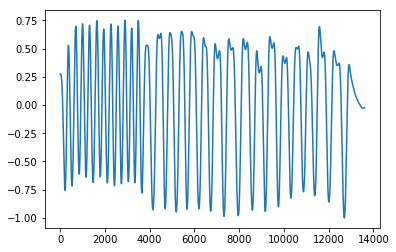

In [10]:
plt.plot(mv_acc[0,::10])

In [11]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#mmsc = MinMaxScaler(feature_range=(0, 1))                            
#raw_data = mmsc.fit_transform(raw_data.T).T
#mv_acc = mmsc.fit_transform(mv_acc.T).T
#raw_acc = mmsc.fit_transform(raw_acc.T).T

In [12]:
len_raw_data = raw_data.shape[1]

In [13]:

raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):]

mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

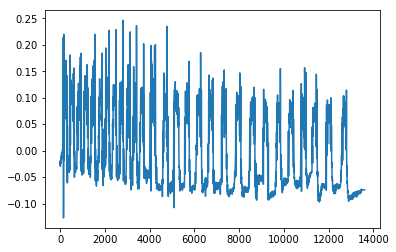

In [14]:
raw_acc = ecog_matfile['raw_acc']
plt.plot(raw_acc[0,::10])

In [15]:
sampling_rate = 2000

In [16]:
raw_acc.shape

(1, 136001)

In [17]:
raw_acc_f = butter_bandpass_filter(raw_acc, 0.1, 1, sampling_rate, order=3, how_to_filt = 'separately')
raw_acc_f.shape

(1, 136001)

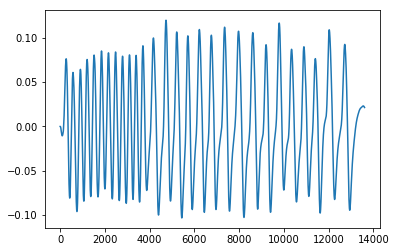

In [18]:
plt.plot(raw_acc_f[0,::10])

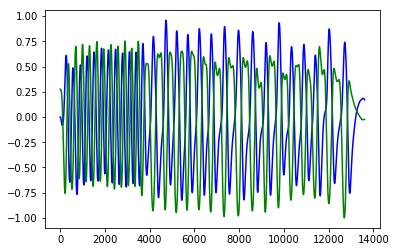

In [19]:
plt.plot(8*raw_acc_f[0,::10],'b',mv_acc[0,::10],'g')

In [20]:
raw_acc = raw_acc_f

In [19]:
mv_acc_train = raw_acc[:,0:(len_raw_data//2)]
mv_acc_val = raw_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = raw_acc[:,(2*len_raw_data//3):]

In [20]:
print(raw_data_train.shape)
print(raw_data_val.shape)
print(raw_data_test.shape)
print(mv_acc_train.shape)
print(mv_acc_val.shape)
print(mv_acc_test.shape)

(4, 68000)
(4, 22667)
(4, 45334)
(1, 68000)
(1, 22667)
(1, 45334)


In [21]:
mv_acc[0,::10].shape

(13601,)

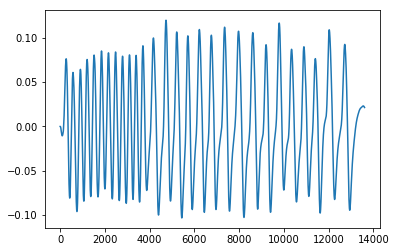

In [22]:
plt.plot(raw_acc[0,::10])

### Functions for data generation (to fit with fit_generator)

In [23]:
def generate_slice(slice_len, val=False, spec=False, test=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    elif ~test:
        X = raw_data_train
        y = mv_acc_train
    else:
        X = raw_data_test
        y = mv_acc_test
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x_raw = X[:,slice_start:slice_end].T
        slice_y = y[0,slice_end]
        
        if(spec):
            f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=750, axis = 0)
            slice_x = np.swapaxes(slice_x,1,2)
            slice_x = slice_x[:50,:,:]
            f = f[:50]
        else:
            slice_x = slice_x_raw
            f = None
            t = None
            
        return slice_x, slice_y, f, t

In [24]:
def data_generator(batch_size, slice_len, val=False, spec=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y, f, t = generate_slice(slice_len, val=val, spec=spec)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

### Training neural network

In [25]:
from keras.layers import Conv2D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling2D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [26]:
slice_len = 2000

nb_filters = 10
kernel_size = 3

dense1_n = 200

dense2_n = 100

do = 0

path_to_save_model = 'testmodel2'

#### Set input size

In [27]:
testx, testy, testf,testt = generate_slice(slice_len, val=True, spec = False)

In [28]:
testx.shape

(2000, 4)

In [29]:
plt.pcolormesh(testt, testf, testx[:,:,0])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

IndexError: too many indices for array

In [39]:
input_size = testx.shape
input_size

(2000, 4)

#### Params

In [40]:
testf

#### Architecture

In [41]:
input_seq = Input(shape=input_size)

convolved = Conv2D(nb_filters, kernel_size=[3,2], padding="same", activation="relu")(input_seq)
convolvedbn = BatchNormalization(axis = -1)(convolved)
pooled = MaxPooling2D()(convolvedbn)

#convolved2 = Conv2D(nb_filters*4, kernel_size=[3,2], padding="same", activation="relu")(pooled)
#convolved2bn = BatchNormalization(axis = -1)(convolved2)
#pooled2 = MaxPooling2D()(convolved2bn)

flat = Flatten()(pooled)

dense1 = Dense(dense1_n, activation="relu")(flat)
dense1bn = BatchNormalization(axis = -1)(dense1)
dense1do = Dropout(do)(dense1bn)

#dense2 = Dense(dense2_n, activation="relu")(dense1do)
#dense2bn = BatchNormalization()(dense2)
#dense2do = Dropout(do)(dense2bn)

out = Dense(1, activation='linear')(dense1do)

model = Model(inputs=input_seq, outputs=out)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

model.summary()

#nb_epoch = 100000


ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=3

#### Early stopping

In [38]:
nb_samples = 3000
nb_val_samples = 1000
nb_epochs = 200
patience = 5

batch_size = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

#### Fit

In [1]:
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size, val=False, spec=True), 
                    steps_per_epoch=nb_samples, 
                    epochs = nb_epochs, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, validation_steps=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True, spec=True))

NameError: name 'model' is not defined

In [ ]:
model.evaluate_generator(data_generator(batch_size=batch_size, slice_len=slice_len, val=False, spec=spec, test=True), 1000)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_loss'])


NameError: name 'history' is not defined

### Testing

In [30]:
model = load_model('testmodel2')

In [31]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],input_size[0],input_size[1],input_size[2]])
tys_0 = np.zeros([idxs.shape[0],1])

NameError: name 'input_size' is not defined

In [107]:
txs_0[0].shape

(501, 7, 4)

In [108]:
k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x_raw = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=500, axis = 0)
    slice_x = np.swapaxes(slice_x,1,2)
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

In [109]:
tys_pred = model.predict(txs_0)

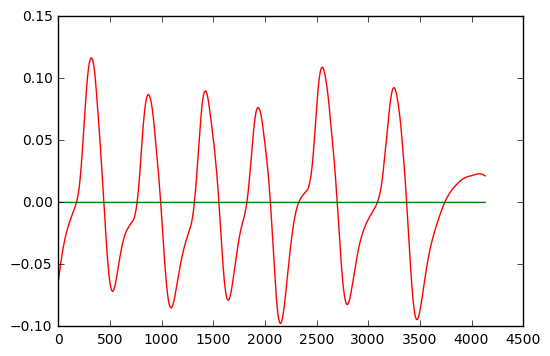

In [110]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()

# Cycle to iterate over parameter values

#### Prepare the network

In [49]:
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
slice_len = 2000

nb_filters = 10
kernel_size = 3

dense1_n = 500
dense2_n = 200
do = 0.5

samples_per_epoch = 1000
nb_val_samples = 500

nb_epoch = 100
patience = 10

batch_size = 32

#### Prepare testing data

In [51]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

# Prototype

In [52]:
input_seq = Input(shape=(slice_len, 4))

inputbn = BatchNormalization(axis = 1)(input_seq)

convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu')(inputbn)
convolvedbn = BatchNormalization()(convolved)
pooled = MaxPooling1D(pool_size=4)(convolvedbn)

convolved2 = Conv1D(nb_filters*4, kernel_size, padding="same", activation='relu')(pooled)
convolved2bn = BatchNormalization()(convolved2)
pooled2 = MaxPooling1D(pool_size=4)(convolved2bn)

convolved3 = Conv1D(nb_filters*16, kernel_size, padding="same", activation='relu')(pooled2)
convolved3bn = BatchNormalization()(convolved3)
pooled3 = MaxPooling1D(pool_size=4)(convolved3bn)

convolved4 = Conv1D(nb_filters*64, kernel_size, padding="same", activation='relu')(pooled3)
convolved4bn = BatchNormalization()(convolved4)
pooled4 = MaxPooling1D(pool_size=4)(convolved4bn)


flat = Flatten()(pooled4)
dense1 = Dense(dense1_n, activation='relu')(flat)
dense1 = BatchNormalization()(dense1)
dense1do = Dropout(do)(dense1)
#dense2 = Dense(dense2_n, activation='relu')(dense1do)
#dense2 = BatchNormalization()(dense2)
#dense2do = Dropout(do)(dense2)
out = Dense(1, activation='linear')(dense1do)
model = Model(input=input_seq, output=out)
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2000, 4)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2000, 4)           8000      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2000, 10)          130       
_________________________________________________________________
batch_normalization_9 (Batch (None, 2000, 10)          40        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 500, 10)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 40)           1240      
_________________________________________________________________
batch_normalization_10 (Batc (None, 500, 40)           160       
__________

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1000, 100, callbacks=[<keras.ca..., validation_data=<generator..., verbose=1, validation_steps=500)`


Epoch 1/100
1000/1000 [==============================] - 29s - loss: 0.2220 - mean_squared_error: 0.2220 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 2/100
1000/1000 [==============================] - 28s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/100
1000/1000 [==============================] - 28s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/100
1000/1000 [==============================] - 28s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/100
1000/1000 [==============================] - 28s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 6/100
1000/1000 [==============================] - 28s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 7/100
1000/1000 [==============================] - 2

Error: token_revoked

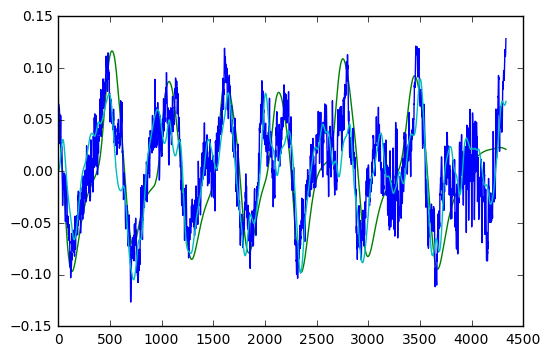

In [53]:
path_to_save_model_par = 'saved_model'
figure_name = 'fig_0_'

# early stopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=1,
                           save_best_only=True, mode='auto', period=1)

# fit model
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=nb_val_samples, 
                validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

# plot progress
plt.clf()
plt.plot(history.history['val_loss'])
plt.savefig(figure_name+'prog')

# test the best model

model = load_model(path_to_save_model_par)

tys_pred = model.predict(txs_0)

sampling_rate = 2000
tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_pred,'b')
plt.plot(tys_pred_f,'c')
plt.savefig(figure_name+'pred')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')


In [ ]:
# fit model
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=nb_val_samples, 
                validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

# plot progress
plt.clf()
plt.plot(history.history['val_loss'])
plt.savefig(figure_name+'prog')


Error: token_revoked

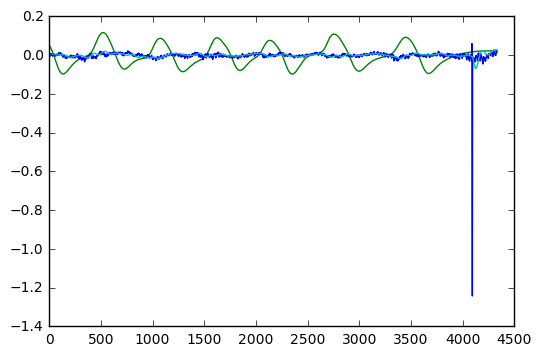

In [48]:
# test the best model

model = load_model(path_to_save_model_par)

tys_pred = model.predict(txs_0)

sampling_rate = 2000
tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T
tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

plt.clf()
plt.plot(tys_0,'g')
plt.plot(tys_pred,'b')
plt.plot(tys_pred_f,'c')
plt.savefig(figure_name+'pred')

cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[:,0],tys_pred_f[:,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')

In [137]:
tys_0.shape

(4434, 1)

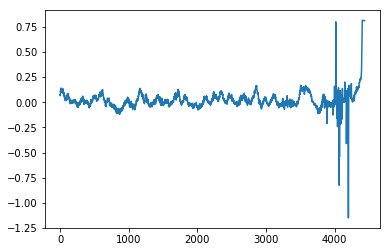

In [159]:
plt.plot(tys_pred[:,0])
#tys_pred_f = butter_bandpass_filter(tys_pred.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

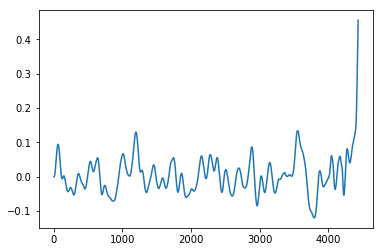

In [160]:
plt.plot(tys_pred_f[:,0])

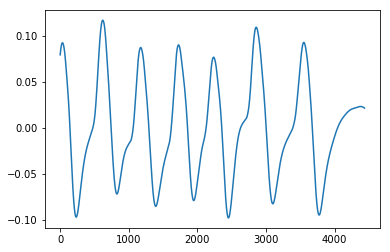

In [162]:
plt.plot(tys_0[:,0])
#tys_0_f = butter_bandpass_filter(tys_0.T, 1, 20, sampling_rate, order=3, how_to_filt = 'simultaneously').T

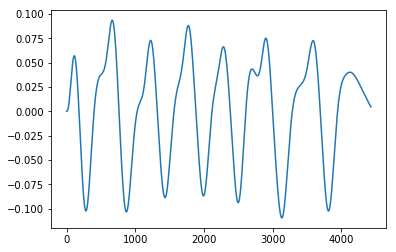

In [163]:
plt.plot(tys_0_f[:,0])

In [134]:
cor = np.corrcoef(tys_0[0:-500,0],tys_pred[0:-500,0])
cor = cor[0,1]
cor_smooth = np.corrcoef(tys_0_f[0:-500,0],tys_pred_f[0:-500,0])
cor_smooth = cor_smooth[0,1]

send_slack_message("\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

send_slack_message("Prediction:")
send_slack_picture(figure_name+'pred'+'.png')

send_slack_message("Training history:")
send_slack_picture(figure_name+'prog'+'.png')

In [26]:
cor_smooth

0.23354311152330565

#### Choose the variable to iterate over here:

In [35]:
## var_name = [ k for k,v in locals().iteritems() if v is var][0] ## sample

In [36]:
var_name = 'dense2_n' # MODIFY VARIABLE NAME HERE

#### Set directory to save best models and figures

In [37]:
dirname = var_name

if not os.path.exists(dirname):
    os.makedirs(dirname)

In [38]:
dirname

'dense2_n'

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1000, 100, callbacks=[<keras.ca..., validation_data=<generator..., verbose=2, validation_steps=500)`


Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.09514, saving model to dense2_n/savedmodel_10
18s - loss: 0.1173 - mean_squared_error: 0.1173 - val_loss: 0.0951 - val_mean_squared_error: 0.0951
Epoch 2/100
Epoch 00001: val_loss improved from 0.09514 to 0.07605, saving model to dense2_n/savedmodel_10
11s - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.0761 - val_mean_squared_error: 0.0761
Epoch 3/100
Epoch 00002: val_loss did not improve
11s - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0811 - val_mean_squared_error: 0.0811
Epoch 4/100
Epoch 00003: val_loss did not improve
11s - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 5/100
Epoch 00004: val_loss did not improve
11s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 6/100
Epoch 00005: val_loss did not improve
11s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0779 - val_mean_squared_erro

ReadTimeout: HTTPSConnectionPool(host='slack.com', port=443): Read timed out. (read timeout=10)

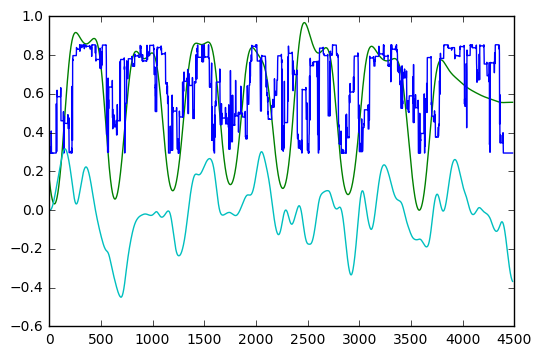

In [108]:
start_time = time()
send_slack_message('New job started at '+ strftime("%H:%M:%S, %Y-%m-%d", gmtime()))

it_range = np.arange(10,200,10)

cors = np.zeros(it_range.shape)
cors_smooth = np.zeros(it_range.shape)

k = 0

for it in it_range:
    
    dense2_n = it # MODIFY VARIABLE NAME HERE
    
    # path to save model
    path_to_save_model_par = dirname+'/'+'savedmodel'+'_'+str(it)
    figure_name = path_to_save_model_par
    
    # build the network
    input_seq = Input(shape=(slice_len, 4))
    
    inputbn = BatchNormalization(axis = 1)(input_seq)
    
    convolved = Conv1D(nb_filters, kernel_size, padding="same", activation='relu')(inputbn)
    pooled = MaxPooling1D()(convolved)
    flat = Flatten()(pooled)
    dense1 = Dense(dense1_n, activation=dense1_act)(flat)
    dense1do = Dropout(do)(dense1)
    dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
    dense2do = Dropout(0.3)(dense2)
    out = Dense(1, activation='linear')(dense2do)
    model = Model(input=input_seq, output=out)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    
    # early stopping
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=2, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=2,
                               save_best_only=True, mode='auto', period=1)

    # fit model
    history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=2, nb_val_samples=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

    # plot progress
    plt.clf()
    plt.plot(history.history['val_loss'])
    plt.savefig(figure_name+'prog')
    
    
    # test the best model
    
    model = load_model(path_to_save_model_par)
    
    tys_pred = model.predict(txs_0)
    
    sampling_rate = 200
    tys_pred_f = butter_bandpass_filter(tys_pred.T, 0.1, 1, sampling_rate, order=3, how_to_filt = 'simultaneously').T
    
    plt.clf()
    plt.plot(tys_0,'g')
    plt.plot(tys_pred,'b')
    plt.plot(tys_pred_f,'c')
    plt.savefig(figure_name+'pred')
    
    cor = np.corrcoef(tys_0[:,0],tys_pred[:,0])
    cor = cor[0,1]
    cor_smooth = np.corrcoef(tys_0[:,0],tys_pred_f[:,0])
    cor_smooth = cor_smooth[0,1]
    
    cors[k] = cor
    
    cors_smooth[k] = cor_smooth
    
    k = k + 1
    
    
    send_slack_message("\nFor "+dirname+"="+str(it)+":"+"\nCorrelation = "+str(cor)+"\nCorrelation (with smoothed) = "+str(cor_smooth))

    send_slack_message("Prediction:")
    send_slack_picture(figure_name+'pred'+'.png')
    
    send_slack_message("Training history:")
    send_slack_picture(figure_name+'prog'+'.png')

plt.clf()
maxi = np.argmax(cors_smooth)
plt.plot(cors_smooth)
plt.savefig('cors_smooth_'+dirname)

send_slack_message("Corrcoef(par):")
send_slack_picture('cors_smooth_'+dirname+'.png')

send_slack_message("Job's done!")
elapsed_time = time() - start_time
send_slack_message("Elapsed time: "+ str(elapsed_time))




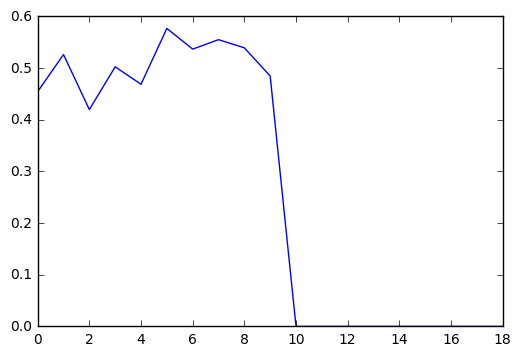

In [109]:
plt.clf()
maxi = np.argmax(cors_smooth)
plt.plot(cors)
plt.savefig('cors_'+dirname)


In [68]:
send_slack_message(teststr)

NameError: name 'teststr' is not defined

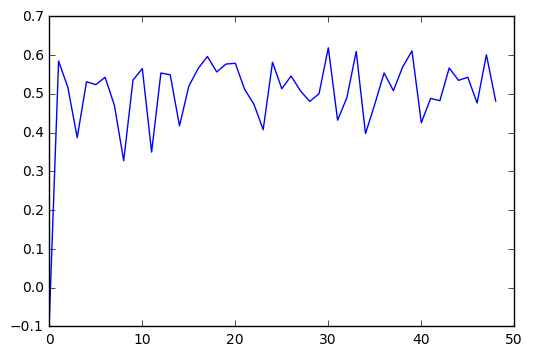

In [28]:
np.corrcoef([1, 2, 8],[2, 4, 16])

array([[ 1.,  1.],
       [ 1.,  1.]])

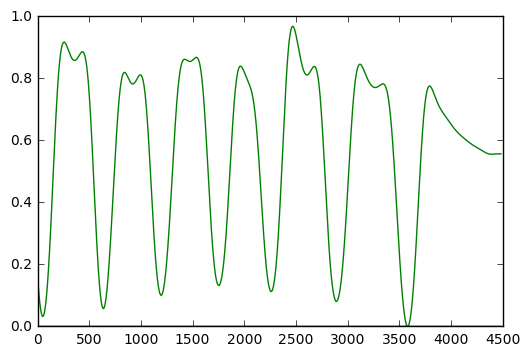

In [111]:

plt.clf()
plt.plot(tys_0,'g')

plt.plot(tys_pred_f,'b')
plt.savefig(figure_name+'pred')

In [114]:
tys_pred_f

array([[  1.07887035e-06],
       [  1.10218862e-06],
       [  1.04646352e-06],
       ..., 
       [  9.01374938e-07],
       [  9.01374938e-07],
       [  9.01374938e-07]])

In [119]:
 tys_pred_f = butter_bandpass_filter(tys_pred.T, 0.1, 1, sampling_rate, order=3, how_to_filt = 'simultaneously').T

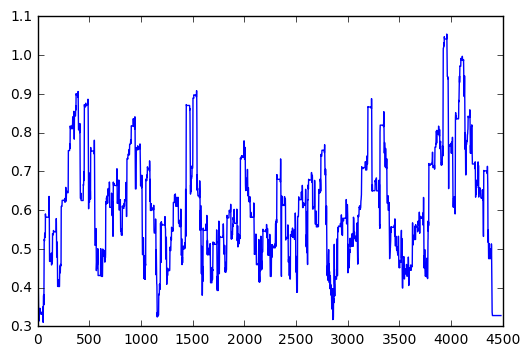

In [120]:
plt.plot(tys_pred)

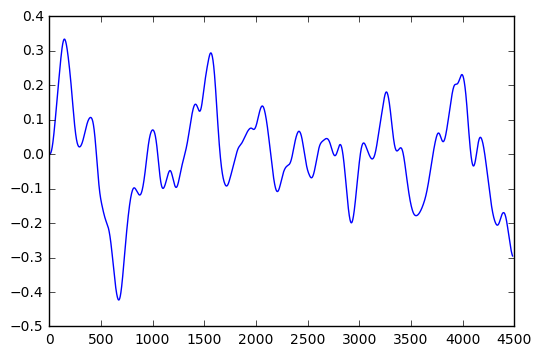

In [121]:
plt.plot(tys_pred_f)